<a href="https://colab.research.google.com/github/AlbertFarkhutdinov/ml_lessons/blob/main/vae_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

## Setup

In [ ]:
import keras
from keras.datasets import mnist
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Classes and functions definitions

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def get_dataset():
    """Return rescale and reshaped MNIST dataset."""
    (_x_train, _y_train), (_x_test, _y_test) = mnist.load_data()
    _x_train = _x_train.astype(np.float32) / _x_train.max()
    _x_test = _x_test.astype(np.float32) / _x_test.max()
    _x_train = np.expand_dims(_x_train, -1)
    _x_test = np.expand_dims(_x_test, -1)
    return (_x_train, _y_train), (_x_test, _y_test)

In [ ]:
def get_encoder(
        input_shape,
        intermediate_dimension: int,
        latent_dimension: int,
):
    encoder_inputs = keras.Input(shape=input_shape)
    intermediate = layers.Flatten()(encoder_inputs)
    intermediate = layers.Dense(
        intermediate_dimension,
        activation="relu",
    )(intermediate)
    z_mean = layers.Dense(latent_dimension, name="z_mean")(intermediate)
    z_log_var = layers.Dense(latent_dimension, name="z_log_var")(intermediate)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
def get_decoder(
        input_shape,
        intermediate_dimension: int,
        latent_dimension: int,
):
    latent_inputs = keras.Input(shape=(latent_dimension,))
    decoder_outputs = layers.Dense(
        intermediate_dimension,
        activation="relu",
    )(latent_inputs)
    decoder_outputs = layers.Dense(
        np.array(input_shape).prod(),
        activation="sigmoid",
    )(decoder_outputs)
    decoder_outputs = layers.Reshape(input_shape)(decoder_outputs)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
def get_kl_loss(z_mean, z_log_var):
    return tf.reduce_mean(
        tf.reduce_sum(
            0.5 * (tf.exp(z_log_var) + tf.square(z_mean) - 1 - z_log_var),
            axis=1,
        )
    )

In [ ]:
def get_reconstruction_loss(data, reconstruction):
    return tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction),
            axis=(1, 2),
        )
    )

In [ ]:
class VariationalAutoEncoder(tf.keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VariationalAutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = get_reconstruction_loss(data, reconstruction)
            kl_loss = get_kl_loss(z_mean, z_log_var)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {metric.name: metric.result() for metric in self.metrics}

In [ ]:
def plot_latent_space(
        decoder,
        linear_digits_number: int = 30,
        fig_size: float = 15,
):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((
        digit_size * linear_digits_number,
        digit_size * linear_digits_number,
    ))
    grid_x = np.linspace(-scale, scale, linear_digits_number)
    grid_y = np.linspace(-scale, scale, linear_digits_number)[::-1]

    for i, y_i in enumerate(grid_y):
        for j, x_j in enumerate(grid_x):
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size,
            ] = decoder.predict(
                np.array([[x_j, y_i]])
            )[0].reshape(digit_size, digit_size)

    plt.figure(figsize=(fig_size, fig_size))
    start_range = digit_size // 2
    end_range = linear_digits_number * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [ ]:
def plot_label_clusters(encoder, data, labels, fig_size):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=fig_size)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Train the VAE

In [ ]:
(x_train, y_train), (x_test, _) = get_dataset()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
KWARGS = {
    'input_shape': mnist_digits.shape[1:],
    'intermediate_dimension': 32,
    'latent_dimension': 2,
}
SHAPE = mnist_digits.shape[1:]
INTERMEDIATE_DIMENSION = 32
LATENT_DIMENSION = 2

In [ ]:
ENCODER = get_encoder(**KWARGS)
ENCODER.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           25120       flatten[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            66          dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
DECODER = get_decoder(**KWARGS)
DECODER.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 25,968
Trainable params: 25,968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
VAE = VariationalAutoEncoder(ENCODER, DECODER)
VAE.compile(optimizer=tf.keras.optimizers.Adam())
VAE.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 4s 5ms/step - total_loss: 226.5017 - reconstruction_loss: 213.4972 - kl_loss: 13.0045
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - total_loss: 185.7846 - reconstruction_loss: 180.2420 - kl_loss: 5.5425
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - total_loss: 177.4053 - reconstruction_loss: 172.4160 - kl_loss: 4.9893
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - total_loss: 173.5770 - reconstruction_loss: 168.8170 - kl_loss: 4.7600
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - total_loss: 171.2112 - reconstruction_loss: 166.4838 - kl_loss: 4.7274
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - total_loss: 169.2723 - reconstruction_loss: 164.4732 - kl_loss: 4.7992
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - total_loss: 167.8770 - reconstruction_loss: 163.0051 - kl_loss: 4.8718
Epoch 8/30
547/547 [======

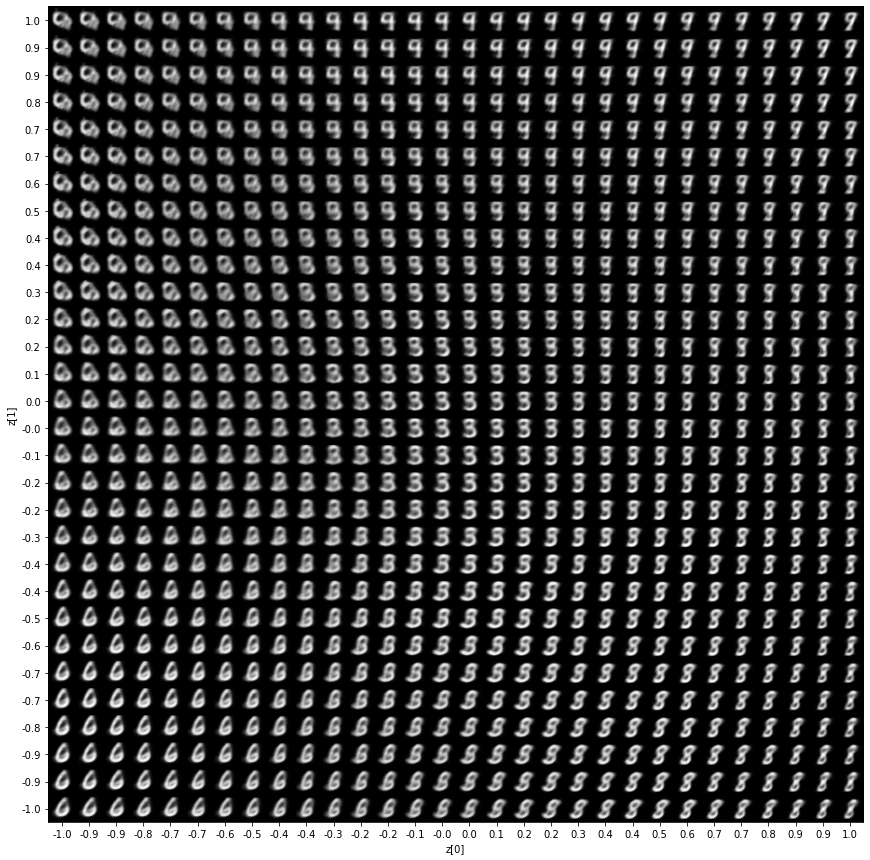

In [ ]:
plot_latent_space(
    decoder=VAE.decoder,
    linear_digits_number=30,
    fig_size=15,
)

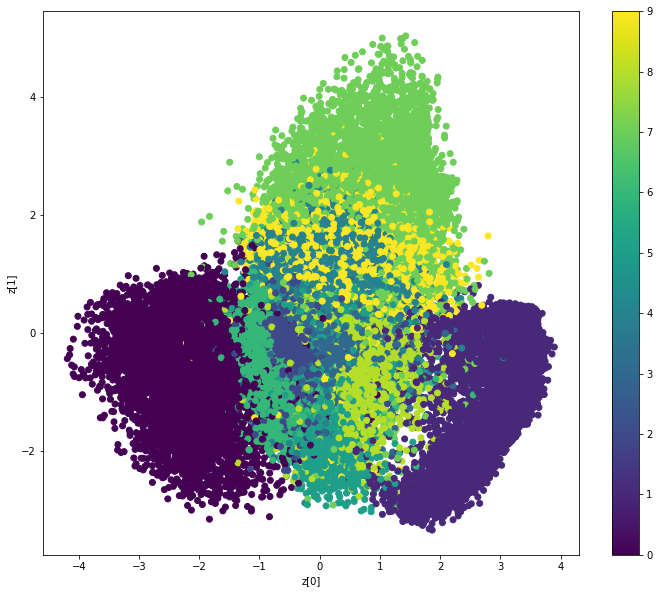

In [ ]:
plot_label_clusters(
  encoder=VAE.encoder,
  data=x_train,
  labels=y_train,
  fig_size=(12, 10),
)